## **Посмотрим сначала на собранные данные**

In [2]:
!wget --no-check-certificate https://raw.githubusercontent.com/Myashka/IVICT.HACK-team-HI/data/dataset.csv

--2022-05-21 18:59:58--  https://raw.githubusercontent.com/Myashka/IVICT.HACK-team-HI/data/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8106782 (7.7M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   7.73M  --.-KB/s    in 0.06s   

2022-05-21 18:59:59 (131 MB/s) - ‘dataset.csv’ saved [8106782/8106782]



In [3]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [7]:
dataset = pd.read_csv("dataset.csv", usecols=[1, 2])
dataset.head(5)

text       label
0  @tiffanylue i know  i was listenin to bad habi...       empty
1  Layin n bed with a headache  ughhhh...waitin o...     sadness
2                Funeral ceremony...gloomy friday...     sadness
3               wants to hang out with friends SOON!  enthusiasm
4  @dannycastillo We want to trade with someone w...     neutral

In [8]:
dataset.label.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger',
       'joy'], dtype=object)

In [9]:
len(dataset.label.unique())

14

In [10]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81459 entries, 0 to 81458
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    81459 non-null  object
 1   label   81459 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [12]:
texts = dataset["text"].tolist()
labels = dataset["label"].values

In [15]:
from sklearn.preprocessing import LabelEncoder

In [17]:
lben = LabelEncoder()
labels = lben.fit_transform(labels)

### Начнем сразу с Bert'а:

Обучим из коробки различные классификаторы sklearn, оценивая accuarcy, f1 и roc-auc

In [6]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 62.0 MB/s 
     |████████████████████████████████| 6.6 MB 58.1 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [13]:
import transformers
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer, logging

In [14]:
logging.set_verbosity_error()  # Ignore warning on model loading.
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Токенезируем наши текстовые данные, посмотрим на то, что возвращает модель

In [18]:
tokenized_texts = tokenizer(
    dataset["text"].tolist(), return_tensors="pt", padding=True, truncation=True
)

for key, values in tokenized_texts.items():
    values_type = type(values).__name__
    print(f"{key}: {values_type}, {values.shape}")

input_ids: Tensor, torch.Size([81459, 110])
attention_mask: Tensor, torch.Size([81459, 110])


Получилось максимально 110 токенов, посмотрим на attention_mask - в конце много нулей, из-за padding

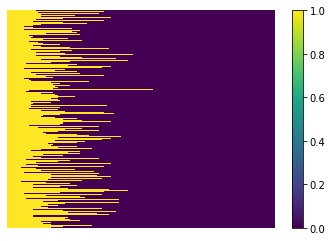

In [19]:
plt.pcolormesh(tokenized_texts["attention_mask"])
plt.axis("off")
plt.colorbar()
plt.show()

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [ ]:
device

device(type='cuda', index=0)

In [21]:
batch_size = 32
features = []
with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        texts_batch = tokenized_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size].to(device)
        output = model(texts_batch, masks_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)

features = np.concatenate(features, axis=0)
features.shape

  0%|          | 0/2546 [00:00<?, ?it/s]

(81459, 768)

Прогнали через Bert все даныне, теперь поищем baseline, для сравнения с нейросетью

### t-SNE

In [22]:
from sklearn.manifold import TSNE

In [33]:
nrows = len(dataset)
total_sample_size = 1e2
balanced_dataset = dataset.groupby("label").apply(
    lambda x: x.sample(int((x.count() / nrows) * total_sample_size))
)

In [25]:
ind = np.random.choice(features.shape[0], features.shape[0] // 6, replace=False)
X = features[ind]
y = labels[ind]

In [26]:
X_embedded = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


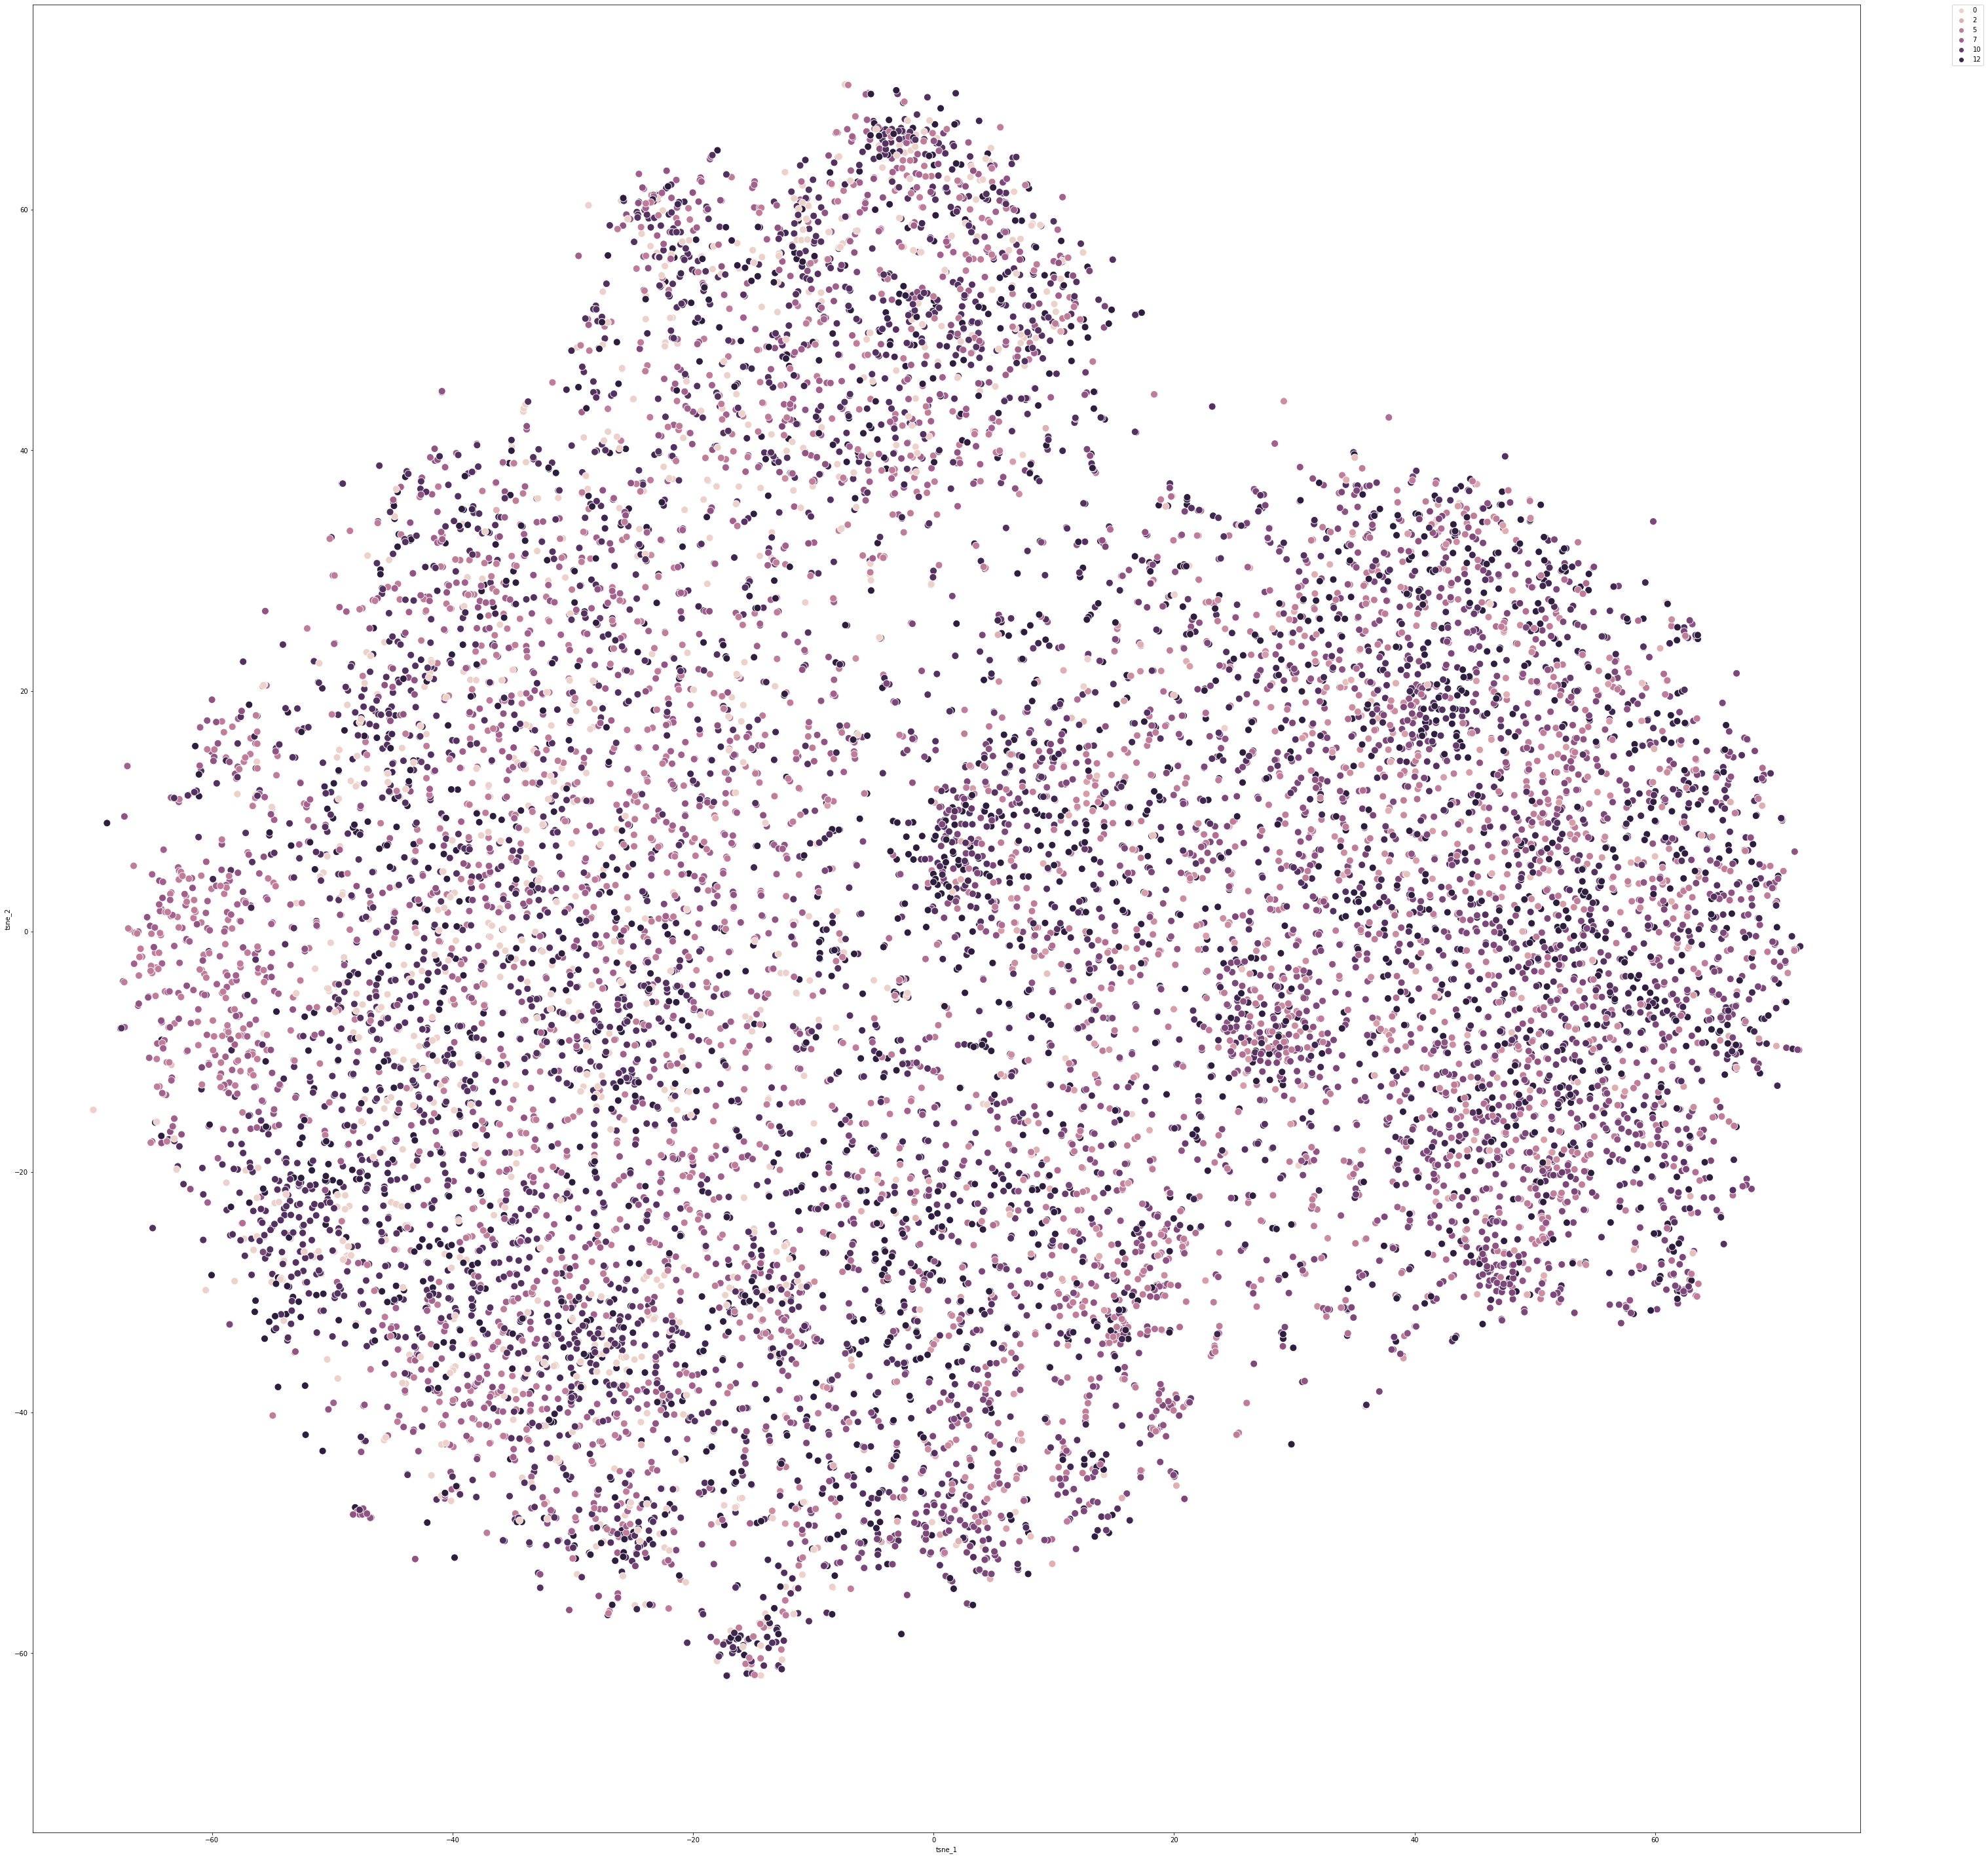

In [28]:
import pandas as pd
import seaborn as sns

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images

# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame(
    {"tsne_1": tsne_result[:, 0], "tsne_2": tsne_result[:, 1], "label": y}
)
fig, ax = plt.subplots(1, figsize=(50, 100))
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect("equal")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Поиск pipeline'а 

In [37]:
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             plot_roc_curve, roc_auc_score)

In [36]:
!pip install scikit-plot

In [43]:
from scikitplot.metrics import plot_roc

In [38]:
def evaluation(pipeline, X_test, y_test):
    y_predict = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    print(classification_report(y_test, y_predict))

    plot_roc(y_test, y_proba, figsize=(10, 8))
    plt.show()
    return {
        "accucary": accuracy_score(y_test, y_predict),
        "f1": f1_score(y_test, y_predict, average="micro"),
        "roc_auc_score_macro": roc_auc_score(
            y_test, y_proba, average="macro", multi_class="ovr"
        ),
    }

In [39]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.3, shuffle=True
)

##### LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
lr_clf = LogisticRegression(class_weight="balanced", solver="saga").fit(
    train_features, train_labels
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.67      0.52      1714
           1       0.03      0.10      0.05        58
           2       0.02      0.89      0.04       275
           3       0.04      0.09      0.06       220
           4       0.00      0.00      0.00       535
           5       0.33      0.05      0.09      3668
           6       0.37      0.05      0.09       406
           7       0.37      0.57      0.45      2106
           8       0.44      0.27      0.34      2167
           9       0.23      0.01      0.02      2609
          10       0.11      0.06      0.07       449
          11       0.69      0.37      0.48      5070
          12       0.30      0.25      0.27      1171
          13       0.60      0.13      0.21      3990

    accuracy                           0.25     24438
   macro avg       0.28      0.25      0.19     24438
weighted avg       0.44      0.25      0.27     24438



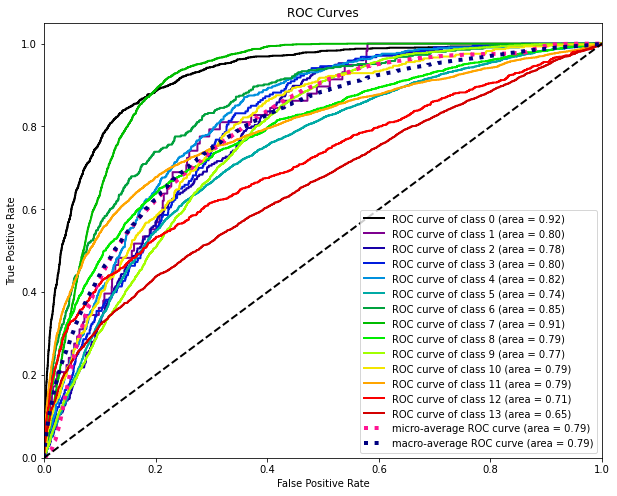

{'accucary': 0.25075701775922743,
 'f1': 0.25075701775922743,
 'roc_auc_score_macro': 0.7940330629823587}

In [44]:
evaluation(lr_clf, test_features, test_labels)

### Test case

In [45]:
text = """Yesterday, all my troubles seemed so far away
Now it looks as though they’re here to stay
Oh, I believe in yesterday.
Suddenly, I’m not half the man I used to be,
There’s a shadow hanging over me.
Oh, yesterday came suddenly.
Why she had to go I don’t know she woldn’t say.
I said something wrong, now I long for yesterday.
Yesterday, love was such an easy game to play.
Now I need a place to hide away.
Oh, I believe in yesterday."""

In [53]:
def predic_from_text(text, classifier):
    with torch.no_grad():
        tokenized_text = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True
        ).to(device)
        output = model(**tokenized_text)
        features = output.last_hidden_state[:, 0, :].cpu().numpy()

    answer = classifier.predict_proba(features)

    emotions_ind = np.argsort(answer)[0][::-1][:6]
    emotions = lben.inverse_transform(classifier.classes_[emotions_ind])
    return emotions, answer

In [54]:
emotions, prediction_probas = predic_from_text(text, lr_clf)

In [55]:
emotions

array(['love', 'surprise', 'happiness', 'sadness', 'worry', 'empty'],
      dtype=object)

###### End of test case

### RandomForest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
rf_clf = RandomForestClassifier().fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1714
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00       275
           3       0.00      0.00      0.00       220
           4       0.00      0.00      0.00       535
           5       0.20      0.23      0.21      3668
           6       0.00      0.00      0.00       406
           7       0.05      0.04      0.04      2106
           8       0.72      0.44      0.55      2167
           9       0.34      0.53      0.41      2609
          10       0.00      0.00      0.00       449
          11       0.60      0.73      0.66      5070
          12       0.98      0.24      0.39      1171
          13       0.42      0.57      0.48      3990

    accuracy                           0.44     24438
   macro avg       0.30      0.25      0.25     24438
weighted avg       0.44      0.44      0.42     24438



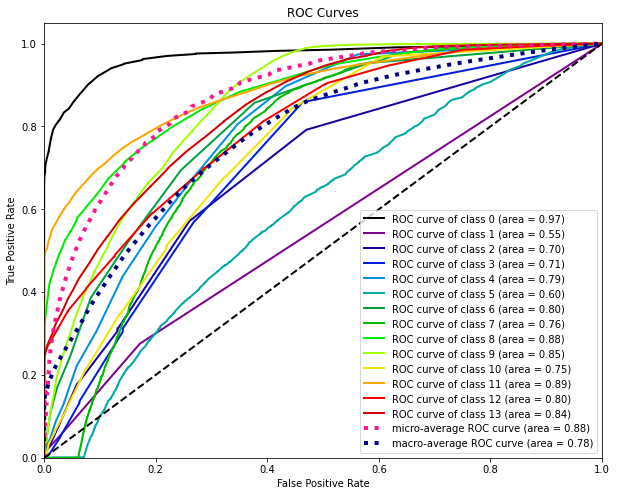

{'accucary': 0.4387429413208937,
 'f1': 0.4387429413208937,
 'roc_auc_score_macro': 0.7783364931152924}

In [63]:
evaluation(rf_clf, test_features, test_labels)

In [64]:
emotions, prediction_probas = predic_from_text(text, rf_clf)

In [65]:
emotions

array(['sadness', 'worry', 'happiness', 'love', 'anger', 'joy'],
      dtype=object)

### kNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
neigh = KNeighborsClassifier().fit(train_features, train_labels)

              precision    recall  f1-score   support

           0       0.31      0.45      0.37      1714
           1       0.00      0.00      0.00        58
           2       0.03      0.04      0.03       275
           3       0.02      0.03      0.02       220
           4       0.07      0.09      0.07       535
           5       0.20      0.25      0.22      3668
           6       0.13      0.06      0.08       406
           7       0.14      0.10      0.12      2106
           8       0.28      0.28      0.28      2167
           9       0.32      0.35      0.33      2609
          10       0.04      0.01      0.02       449
          11       0.44      0.50      0.47      5070
          12       0.18      0.08      0.11      1171
          13       0.33      0.26      0.30      3990

    accuracy                           0.29     24438
   macro avg       0.18      0.18      0.17     24438
weighted avg       0.28      0.29      0.28     24438



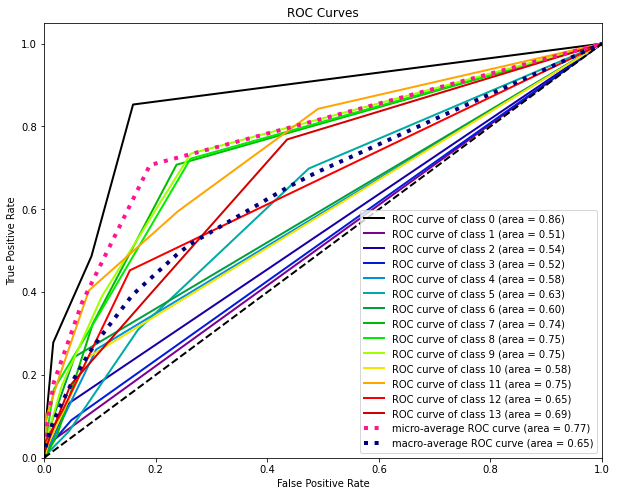

{'accucary': 0.2928226532449464,
 'f1': 0.2928226532449464,
 'roc_auc_score_macro': 0.6534338365432981}

In [59]:
evaluation(neigh, test_features, test_labels)

In [66]:
emotions, prediction_probas = predic_from_text(text, neigh)

In [67]:
emotions

array(['sadness', 'joy', 'happiness', 'anger', 'worry', 'surprise'],
      dtype=object)

### CatBoosting

In [68]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [69]:
!pip install ipywidgets

In [70]:
from catboost import CatBoostClassifier, Pool

In [82]:
embedding_features = list(range(0, 15))

train_dataset = Pool(data=train_features, label=train_labels)

eval_dataset = Pool(data=test_features, label=test_labels)
grid = {
    "learning_rate": [0.03, 0.1, 1],
    "depth": [4, 6, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True)
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=100, learning_rate=1, depth=4, loss_function="MultiClass"
)
# Fit model
model.fit(train_dataset, plot=True)
# Get predicted classes
preds_class = model.predict(eval_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_dataset, prediction_type="RawFormulaVal")

0:	learn: 2.2596338	total: 2.86s	remaining: 4m 43s
1:	learn: 2.1539854	total: 5.36s	remaining: 4m 22s
2:	learn: 2.0717917	total: 7.58s	remaining: 4m 5s
3:	learn: 2.0316803	total: 10.3s	remaining: 4m 6s
4:	learn: 1.9955531	total: 12.8s	remaining: 4m 2s
5:	learn: 1.9750448	total: 15s	remaining: 3m 54s
6:	learn: 1.9566979	total: 17.5s	remaining: 3m 52s
7:	learn: 1.9263824	total: 21.3s	remaining: 4m 5s
8:	learn: 1.9087797	total: 25.7s	remaining: 4m 20s
9:	learn: 1.8968176	total: 30.3s	remaining: 4m 32s
10:	learn: 1.8843701	total: 32.2s	remaining: 4m 20s
11:	learn: 1.8713247	total: 34.2s	remaining: 4m 10s
12:	learn: 1.8570205	total: 36.7s	remaining: 4m 5s
13:	learn: 1.8469439	total: 39.1s	remaining: 4m
14:	learn: 1.8382083	total: 41.1s	remaining: 3m 52s
15:	learn: 1.8293104	total: 43s	remaining: 3m 45s
16:	learn: 1.8217265	total: 45.1s	remaining: 3m 40s
17:	learn: 1.8134567	total: 46.9s	remaining: 3m 33s
18:	learn: 1.8049686	total: 49.6s	remaining: 3m 31s
19:	learn: 1.7986712	total: 51.6s	r

              precision    recall  f1-score   support

           0       0.43      0.40      0.41      1714
           1       0.17      0.02      0.03        58
           2       0.04      0.00      0.01       275
           3       0.14      0.01      0.02       220
           4       0.09      0.03      0.05       535
           5       0.28      0.30      0.29      3668
           6       0.13      0.06      0.08       406
           7       0.28      0.25      0.26      2106
           8       0.34      0.28      0.31      2167
           9       0.34      0.48      0.40      2609
          10       0.10      0.03      0.04       449
          11       0.48      0.57      0.52      5070
          12       0.29      0.10      0.15      1171
          13       0.35      0.39      0.37      3990

    accuracy                           0.36     24438
   macro avg       0.25      0.21      0.21     24438
weighted avg       0.34      0.36      0.34     24438



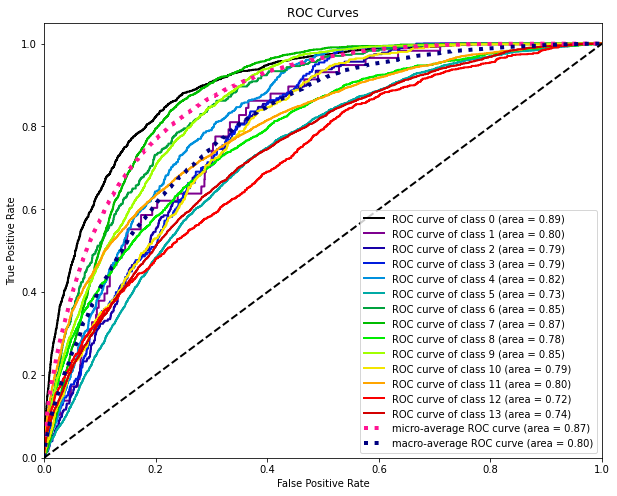

{'accucary': 0.36021769375562646,
 'f1': 0.36021769375562646,
 'roc_auc_score_macro': 0.8008152605897196}

In [83]:
evaluation(model, test_features, test_labels)

На данный момент исследования, нейронная сеть показывает после 2ух эпох Accuracy 0,55, поэтому считаю, что нет смысла оптимизировать гиперпараметры этих моделей